Fourth figure of the manuscript, showing Cross-correlation analyses. 
- Fitting results
- brain maps
- correlations of spatial parameter b with timescales for LFP and gamma

In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
from pathlib import Path
from copy import deepcopy
import pandas as pd
import numpy as np
from scipy.stats import zscore, bootstrap, ttest_rel, false_discovery_control
import matplotlib.pyplot as plt
import mne
import nilearn
from nilearn import surface as nisurf

import mni_utils as uti
from mni_plots import (
    plot_parcellated_metric,
    half_violin_plot,
    plot_corr,
    slope_plot,
    plot_sc_fit,
    plot_hip_amy,
)

Paths and names:

In [3]:
data_path = Path("F:\\iEEG_neural_dynamics\\MNIOpen")
lfp_path = data_path.joinpath("Results_SC")
gamma_path = data_path.joinpath("Results_SC_gamma")
tau_path = data_path.joinpath("Results_acf_fit_exp")
tau_gamma_path = data_path.joinpath("Results_gamma")
fig_path = data_path.joinpath("Figures")

Destrieux Parcellation:

In [4]:
subjects_dir = str(mne.datasets.sample.data_path()) + "/subjects"
parc_map_name = "aparc.a2009s"
annot_file = annot_file = (
    subjects_dir + "/fsaverage/label/lh." + parc_map_name + ".annot"
)
parc_labels = mne.read_labels_from_annot(
    "fsaverage", parc_map_name, "lh", subjects_dir=subjects_dir
)

Reading labels from parcellation...
   read 75 labels from C:\Users\ricca\mne_data\MNE-sample-data\subjects\fsaverage\label\lh.aparc.a2009s.annot


MNIA - Destrieux mapping:

In [5]:
df_mnia_dest = pd.read_excel(
    data_path.joinpath("mnia_Destrieux_labels.xlsx"), index_col=0
)
df_mnia_dest["Destrieux atlas name"] = df_mnia_dest["Destrieux atlas name"].str.strip(
    "'"
)
df_mnia_dest.rename(
    columns={
        "Destrieux atlas name": "Destrieux",
        "MNIA equivalent": "MNIA",
    },
    inplace=True,
)
df_mnia_dest.drop(columns="Expanded name", inplace=True)

Hippocampus and Amygdala surface:

In [6]:
surface_hip_amy = nisurf.load_surf_mesh(data_path.joinpath("surfaces/Hip_Amy.surf.gii"))
surface_hip_amy = uti.project_hemis_surf(surface_hip_amy, hemis="left")

Harvard-Oxford dataset for subcortical structures:

In [7]:
HO_atlas = nilearn.datasets.fetch_atlas_harvard_oxford(
    "sub-maxprob-thr50-1mm", symmetric_split=False
)

SC results and parameters:

In [12]:
# LFP results
# Dataframe with data on all channles pairs
df_sc_stages = {
    stage: pd.read_csv(lfp_path.joinpath(f"SC_{stage}.csv"), index_col=0)
    for stage in ["W", "N3", "R"]
}
# Dataframe with the fit parameters of df_sc_bins_stages
df_sc_params_stages = {
    stage: pd.read_csv(lfp_path.joinpath(f"SC_{stage}_fit.csv"), index_col=0)
    for stage in ["W", "N3", "R"]
}
# Dataframe with the fit parameters on each MNI region
df_sc_params_mni_stages = {
    stage: pd.read_csv(lfp_path.joinpath(f"SC_{stage}_fit_mni_regs.csv"), index_col=0)
    for stage in ["W", "N3", "R"]
}

# Gamma results
# Dataframe with data on all channles pairs
df_sc_stages_gamma = {
    stage: pd.read_csv(gamma_path.joinpath(f"SC_{stage}.csv"), index_col=0)
    for stage in ["W", "N3", "R"]
}
# Dataframe with the fit parameters of df_sc_bins_stages
df_sc_params_stages_gamma = {
    stage: pd.read_csv(gamma_path.joinpath(f"SC_{stage}_fit.csv"), index_col=0)
    for stage in ["W", "N3", "R"]
}
# Dataframe with the fit parameters on each MNI region
df_sc_params_mni_stages_gamma = {
    stage: pd.read_csv(gamma_path.joinpath(f"SC_{stage}_fit_mni_regs.csv"), index_col=0)
    for stage in ["W", "N3", "R"]
}

Timescales:

In [9]:
# Dataframe with timescales for all electrodes
df_tau = pd.read_csv(tau_path.joinpath("all_tau.csv"), index_col=0)
df_tau_gamma = pd.read_csv(tau_gamma_path.joinpath("all_tau.csv"), index_col=0)

### A) Plot Correlation vs distance plots 

LFP:

{'W': array([11.22826961,  0.42215823,  0.05434913]), 'N3': array([10.27736862,  0.34869673,  0.07936772]), 'R': array([10.21590359,  0.33860094,  0.05660107])}


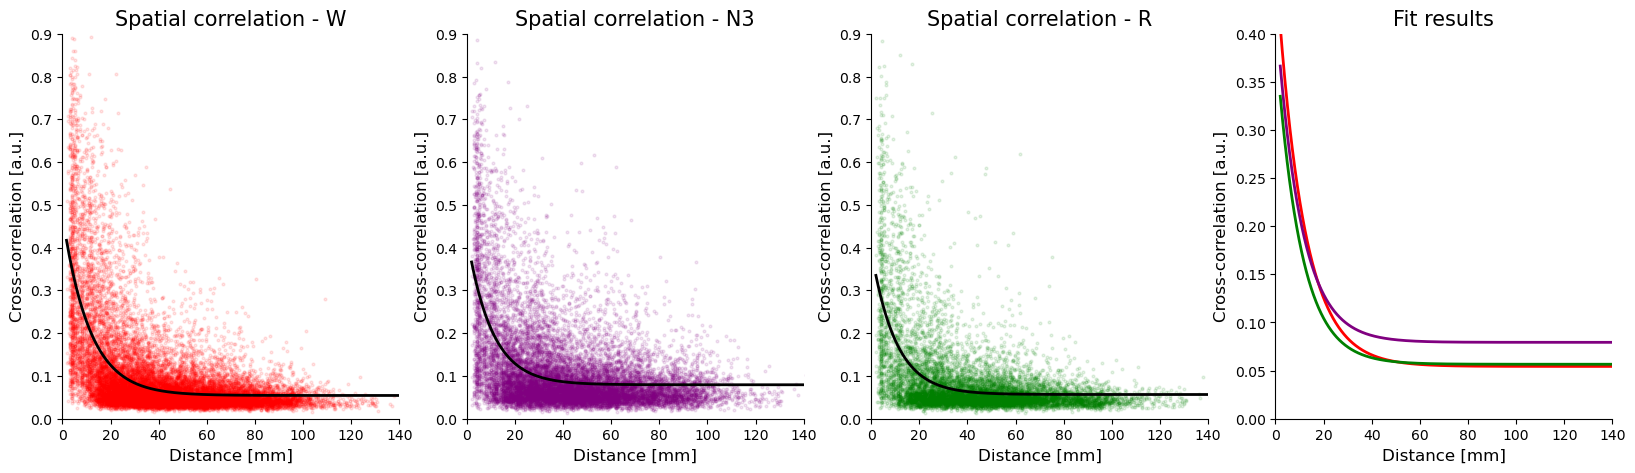

In [17]:
colors_stage = {"W": "r", "N3": "purple", "R": "g"}
params_stages = {
    stage: par.to_numpy().squeeze() for stage, par in df_sc_params_stages.items()
}
print(params_stages)
fig, axs = plot_sc_fit(df_sc_stages, params_stages, colors_stage)
for i, ax in enumerate(axs):
    if i == 3:
        ax.set_ylim(0, 0.4)
    else:
        ax.set_ylim(0, 0.9)
    ax.set_xlim(0, 140)
fig.savefig(fig_path.joinpath("Fig_4", "Fig_4_fit_stages.svg"), format="svg")
plt.show()

Gamma:

{'W': array([6.75415482, 0.03953002, 0.00967877]), 'N3': array([6.39203251, 0.06212093, 0.01303064]), 'R': array([5.59125003, 0.03905028, 0.01042404])}


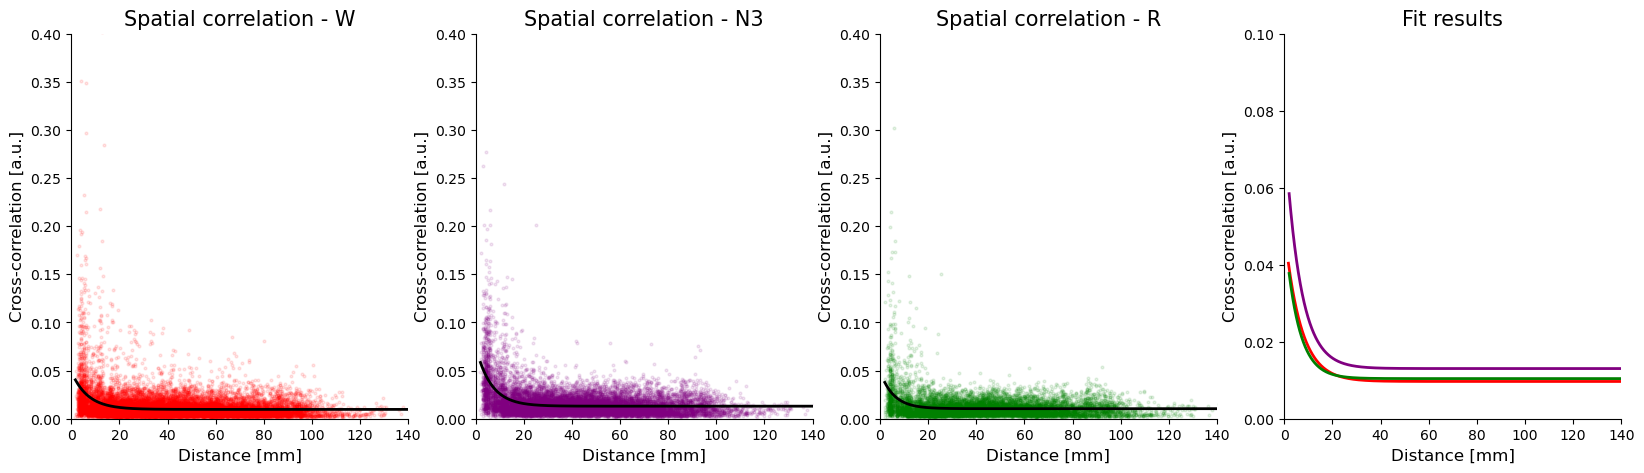

In [19]:
colors_stage = {"W": "r", "N3": "purple", "R": "g"}
params_stages = {
    stage: par.to_numpy().squeeze() for stage, par in df_sc_params_stages_gamma.items()
}
print(params_stages)
fig, axs = plot_sc_fit(df_sc_stages_gamma, params_stages, colors_stage)
for i, ax in enumerate(axs):
    if i == 3:
        ax.set_ylim(0, 0.1)
    else:
        ax.set_ylim(0, 0.4)
    ax.set_xlim(0, 140)
fig.savefig(fig_path.joinpath("Fig_4", "Fig_4_fit_stages_gamma.svg"), format="svg")
plt.show()

### B) Brain map of b parameter

LFP:

In [40]:
title_dict = {"W": "Wake", "N3": "NREM3", "R": "REM"}

# Plot parameters for each stage
for stage in ["W", "N3", "R"]:
    print(stage)

    # Select dataframe for the stage for MNI regions
    df_stage_mni = df_sc_params_mni_stages[stage].copy()

    for param in ["b"]:

        # Convert to Destrieux regions
        df_stage_dest = df_mnia_dest.copy()
        df_stage_dest.dropna(inplace=True)
        df_stage_dest[param] = df_stage_mni.loc[
            df_stage_dest["MNIA"].to_list(), param
        ].to_list()
        df_stage_dest = df_stage_dest[["Destrieux", param]].groupby("Destrieux").mean()

        # Create parcellation on cortex
        N_vert = max([max(label.vertices) for label in parc_labels])
        dest_plot_parc = np.zeros((N_vert + 1), dtype=int)
        parc_names = [label.name[:-3] for label in parc_labels]

        for i, (name, label) in enumerate(zip(parc_names, parc_labels)):
            if name in df_stage_dest.index:
                dest_plot_parc[label.vertices] = i + 1

        # Select data for plot and limits
        data_plot = df_stage_dest.loc[parc_names[:-1]].to_numpy().squeeze()
        lims_plot = np.quantile(df_stage_mni[param].to_numpy(), [0.0, 1.0])

        # Plot on cortex
        cbar_ticks = list(np.round(np.linspace(lims_plot[0], lims_plot[1], 4), 3)[1:-1])
        cbar_ticks.insert(0, np.ceil(lims_plot[0] * 1000) / 1000)
        cbar_ticks.append(np.floor(lims_plot[1] * 1000) / 1000)
        fig, ax = plot_parcellated_metric(
            data_plot,
            dest_plot_parc,
            subjects_dir,
            log_scale=False,
            minmax=lims_plot,
            title=title_dict[stage],
            cmap="inferno",
            label="long-range correlations [a.u.]",
            cbar_format="3f",
            cbar_ticks=cbar_ticks,
        )
        fig.savefig(
            fig_path.joinpath("Fig_4", f"{param}_mni_parc_{stage}_ctx.svg"),
            format="svg",
        )
        plt.close(fig)

        # Plot on hippocampus and amygdala
        surface_nodes_labels = uti.get_hip_amy_vtx(HO_atlas, surface_hip_amy)
        val_amy = df_stage_mni.loc["Amygdala", param]
        val_hip = df_stage_mni.loc["Hippocampus", param]
        fig = plot_hip_amy(
            surface_hip_amy, val_hip, val_amy, surface_nodes_labels, lims_plot
        )
        fig.write_image(
            fig_path.joinpath("Fig_4", f"{param}_mni_parc_{stage}_hipamy.svg"),
            format="svg",
        )

W
N3
R


Gamma:

In [41]:
title_dict = {"W": "Wake", "N3": "NREM3", "R": "REM"}

# Plot parameters for each stage
for stage in ["W", "N3", "R"]:
    print(stage)

    # Select dataframe for the stage for MNI regions
    df_stage_mni = df_sc_params_mni_stages_gamma[stage].copy()

    for param in ["b"]:

        # Convert to Destrieux regions
        df_stage_dest = df_mnia_dest.copy()
        df_stage_dest.dropna(inplace=True)
        df_stage_dest[param] = df_stage_mni.loc[
            df_stage_dest["MNIA"].to_list(), param
        ].to_list()
        df_stage_dest = df_stage_dest[["Destrieux", param]].groupby("Destrieux").mean()

        # Create parcellation on cortex
        N_vert = max([max(label.vertices) for label in parc_labels])
        dest_plot_parc = np.zeros((N_vert + 1), dtype=int)
        parc_names = [label.name[:-3] for label in parc_labels]

        for i, (name, label) in enumerate(zip(parc_names, parc_labels)):
            if name in df_stage_dest.index:
                dest_plot_parc[label.vertices] = i + 1

        # Select data for plot and limits
        data_plot = df_stage_dest.loc[parc_names[:-1]].to_numpy().squeeze()
        lims_plot = np.quantile(df_stage_mni[param].to_numpy(), [0, 1.0])

        # Plot on cortex
        cbar_ticks = list(np.round(np.linspace(lims_plot[0], lims_plot[1], 4), 3)[1:-1])
        cbar_ticks.insert(0, np.ceil(lims_plot[0] * 1000) / 1000)
        cbar_ticks.append(np.floor(lims_plot[1] * 1000) / 1000)
        fig, ax = plot_parcellated_metric(
            data_plot,
            dest_plot_parc,
            subjects_dir,
            log_scale=False,
            minmax=lims_plot,
            title=title_dict[stage],
            cmap="inferno",
            label="long-range correlations [a.u.]",
            cbar_format="3f",
            cbar_ticks=cbar_ticks,
        )
        fig.savefig(
            fig_path.joinpath("Fig_4", f"{param}_mni_parc_{stage}_ctx_gamma.svg"),
            format="svg",
        )
        plt.close(fig)

        # Plot on hippocampus and amygdala
        surface_nodes_labels = uti.get_hip_amy_vtx(HO_atlas, surface_hip_amy)
        val_amy = df_stage_mni.loc["Amygdala", param]
        val_hip = df_stage_mni.loc["Hippocampus", param]
        fig = plot_hip_amy(
            surface_hip_amy, val_hip, val_amy, surface_nodes_labels, lims_plot
        )
        fig.write_image(
            fig_path.joinpath("Fig_4", f"{param}_mni_parc_{stage}_hipamy_gamma.svg"),
            format="svg",
        )

W
N3
R


### C) Average increase of during sleep

LFP:

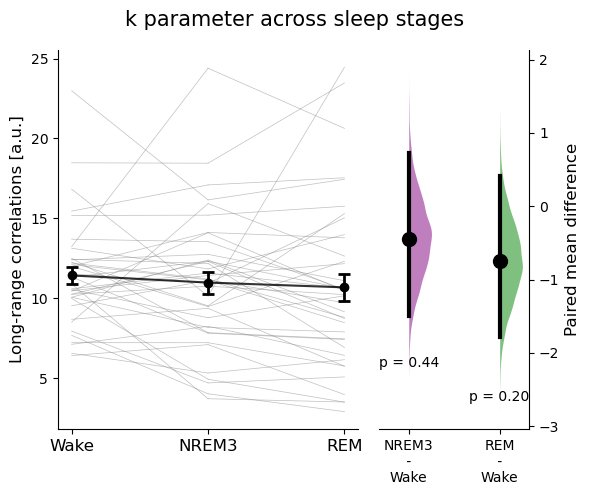

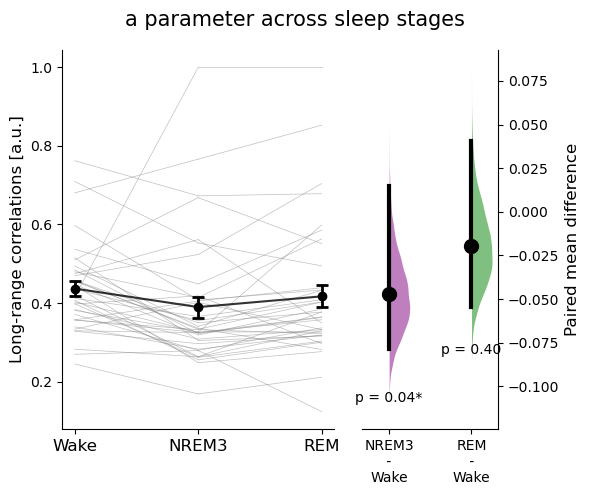

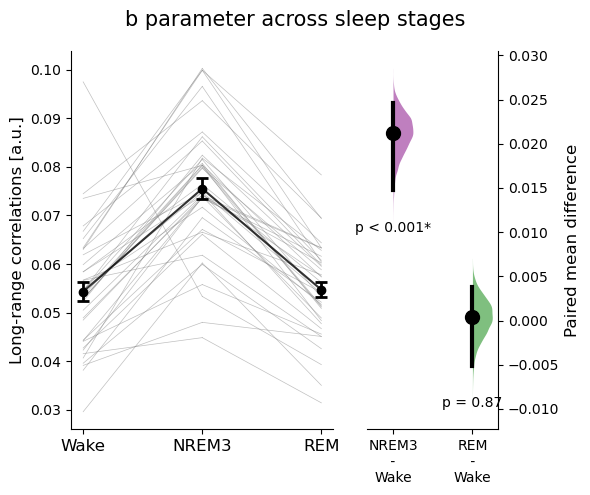

In [50]:
for param in ["k", "a", "b"]:

    # Add stage to the dataframe
    df_metric = deepcopy(df_sc_params_mni_stages)
    df_metric["W"]["stage"] = "W"
    df_metric["N3"]["stage"] = "N3"
    df_metric["R"]["stage"] = "R"
    df_metric = pd.concat(df_metric.values())
    df_metric = df_metric.pivot(columns="stage", values=param)
    df_metric["ID"] = np.arange(len(df_metric.index))

    stage_colors = {"W": "red", "N3": "purple", "R": "green"}


    fig, axs = plt.subplots(1, 2, figsize=(6, 5), width_ratios=[2, 1], layout="tight")


    df_metric_plot = df_metric[["W", "N3", "R"]].copy()


    axs[0] = slope_plot(axs[0], df_metric_plot, ylabel="Long-range correlations [a.u.]")


    axs[0].set_xticks([0, 1, 2], ["Wake", "NREM3", "REM"], fontsize=12)


    # axs[0].set_ylim(0.02, 0.11)


    # Add contrasts


    def avg_diff(x, y):


        return np.mean(x - y)


    # Plot differences


    for i, stage in enumerate(["N3", "R"]):


        avg = avg_diff(df_metric_plot[stage], df_metric_plot["W"])


        pval = ttest_rel(df_metric_plot[stage], df_metric_plot["W"])[1]


        p_str = f"p = {pval:.2f}" if pval >= 0.001 else "p < 0.001"


        p_str += "*" if pval < 0.05 else ""


        res_boot = bootstrap(
            (df_metric_plot[stage], df_metric_plot["W"]),
            avg_diff,
            paired=True,
            random_state=290496,
        )


        axs[1] = half_violin_plot(
            axs[1],
            avg,
            x_pos=i,
            ci=list(res_boot.confidence_interval),
            y_boot=res_boot.bootstrap_distribution,
            color=stage_colors[stage],

            pval=p_str,
        )


    # axs[1].set_ylim(-0.01, 0.03)


    axs[1].set_ylabel("Paired mean difference", fontsize=12)


    axs[1].yaxis.set_label_position("right")


    axs[1].yaxis.tick_right()


    axs[1].set_xticks([0, 1], ["NREM3\n - \nWake", "REM\n - \nWake"], fontsize=10)


    axs[1].spines[["top", "left"]].set_visible(False)


    fig.suptitle(f"{param} parameter across sleep stages", fontsize=15)


    plt.subplots_adjust(wspace=0.5)


    fig.savefig(
        fig_path.joinpath("Fig_4", f"Fig4_{param}_change_stages.svg"), format="svg"
    )


    plt.show()

Gamma:

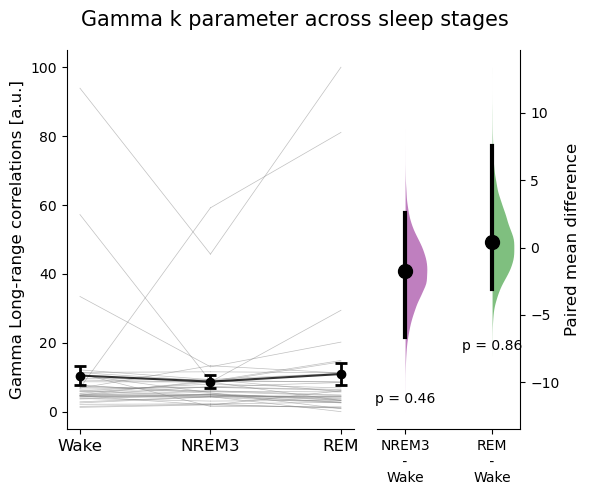

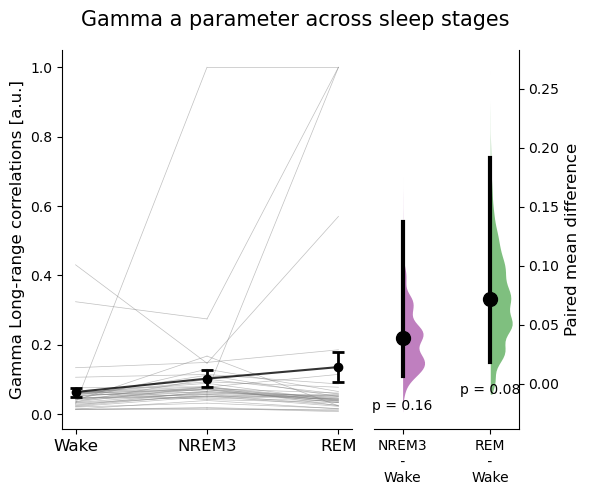

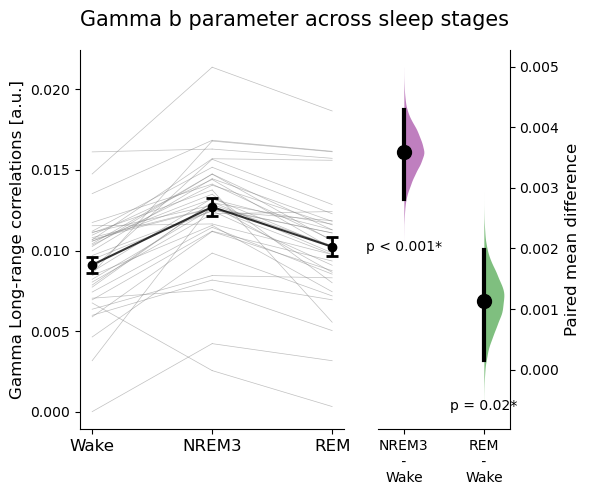

In [51]:
for param in ["k", "a", "b"]:

    # Add stage to the dataframe
    df_metric = deepcopy(df_sc_params_mni_stages_gamma)
    df_metric["W"]["stage"] = "W"
    df_metric["N3"]["stage"] = "N3"
    df_metric["R"]["stage"] = "R"
    df_metric = pd.concat(df_metric.values())
    df_metric = df_metric.pivot(columns="stage", values=param)
    df_metric["ID"] = np.arange(len(df_metric.index))

    stage_colors = {"W": "red", "N3": "purple", "R": "green"}

    fig, axs = plt.subplots(1, 2, figsize=(6, 5), width_ratios=[2, 1], layout="tight")

    df_metric_plot = df_metric[["W", "N3", "R"]].copy()
    axs[0] = slope_plot(
        axs[0], df_metric_plot, ylabel="Gamma Long-range correlations [a.u.]"
    )
    axs[0].set_xticks([0, 1, 2], ["Wake", "NREM3", "REM"], fontsize=12)
    # axs[0].set_ylim(0.02, 0.11)

    # Add contrasts
    def avg_diff(x, y):
        return np.mean(x - y)

    # Plot differences
    for i, stage in enumerate(["N3", "R"]):
        avg = avg_diff(df_metric_plot[stage], df_metric_plot["W"])
        pval = ttest_rel(df_metric_plot[stage], df_metric_plot["W"])[1]
        p_str = f"p = {pval:.2f}" if pval >= 0.001 else "p < 0.001"
        p_str += "*" if pval < 0.05 else ""
        res_boot = bootstrap(
            (df_metric_plot[stage], df_metric_plot["W"]),
            avg_diff,
            paired=True,
            random_state=290496,
        )
        axs[1] = half_violin_plot(
            axs[1],
            avg,
            x_pos=i,
            ci=list(res_boot.confidence_interval),
            y_boot=res_boot.bootstrap_distribution,
            color=stage_colors[stage],
            pval=p_str,
        )
    # axs[1].set_ylim(-0.01, 0.03)
    axs[1].set_ylabel("Paired mean difference", fontsize=12)
    axs[1].yaxis.set_label_position("right")
    axs[1].yaxis.tick_right()
    axs[1].set_xticks([0, 1], ["NREM3\n - \nWake", "REM\n - \nWake"], fontsize=10)
    axs[1].spines[["top", "left"]].set_visible(False)

    fig.suptitle(f"Gamma {param} parameter across sleep stages", fontsize=15)
    plt.subplots_adjust(wspace=0.5)

    fig.savefig(
        fig_path.joinpath("Fig_4", f"Fig4_{param}_change_stages_gamma.svg"),
        format="svg",
    )
    plt.show()

### D) Correlation with Timescales

In [52]:
map_coords = pd.read_csv(data_path.joinpath("mnia_centroids_coords.csv"), index_col=0)

In [ ]:
false_discovery_control([0.005, 0.002, 0.058, 0.332, 0.135, 0.842, 0.167, 0.001, 0.042])

LFP:

In [63]:
# Gather all p-values to correct
df_rhos = pd.DataFrame(index=["k", "a", "b"], columns=["W", "N3", "R"], dtype=float)
df_pvals = pd.DataFrame(index=["k", "a", "b"], columns=["W", "N3", "R"], dtype=float)
rhos_boot = {stage: {} for stage in ["W", "N3", "R"]}

# Plot one figure per parameter
for i, stage in enumerate(["W", "N3", "R"]):

    # Get average tau per MNI region
    df_tau_stage_mni = uti.get_avg_tau_mni(
        df_tau[df_tau["stage"] == stage].copy(), method="LME"
    )

    for param in ["k", "a", "b"]:

        print(f"Stage: {stage}, Param: {param}")

        # Get spatial parameter
        df_spa = df_sc_params_mni_stages[stage][param].astype(float)
        df_spa = df_spa.loc[df_tau_stage_mni.index]

        # Get correlation values
        rho, p_corr = uti.get_pcorr_mnia(
            df_tau_stage_mni, df_spa, map_coords, method="vasa", corr_type="pearson"
        )

        df_rhos.loc[param, stage] = rho
        df_pvals.loc[param, stage] = p_corr
        rhos_boot[stage][param] = uti.get_rho_boot(
            df_tau_stage_mni, df_spa, corr_type="pearson"
        )


# Correct with FDR correction
pvals_corr = false_discovery_control(df_pvals.to_numpy().ravel())
df_pvals_corr = pd.DataFrame(
    pvals_corr.reshape(df_pvals.shape), index=df_pvals.index, columns=df_pvals.columns
)

Stage: W, Param: k
Generating 1000 permutations...
Stage: W, Param: a
Generating 1000 permutations...
Stage: W, Param: b
Generating 1000 permutations...
Stage: N3, Param: k
Generating 1000 permutations...
Stage: N3, Param: a
Generating 1000 permutations...
Stage: N3, Param: b
Generating 1000 permutations...
Stage: R, Param: k
Generating 1000 permutations...
Stage: R, Param: a
Generating 1000 permutations...
Stage: R, Param: b
Generating 1000 permutations...


Stage: W, Param: k
Stage: N3, Param: k
Stage: R, Param: k


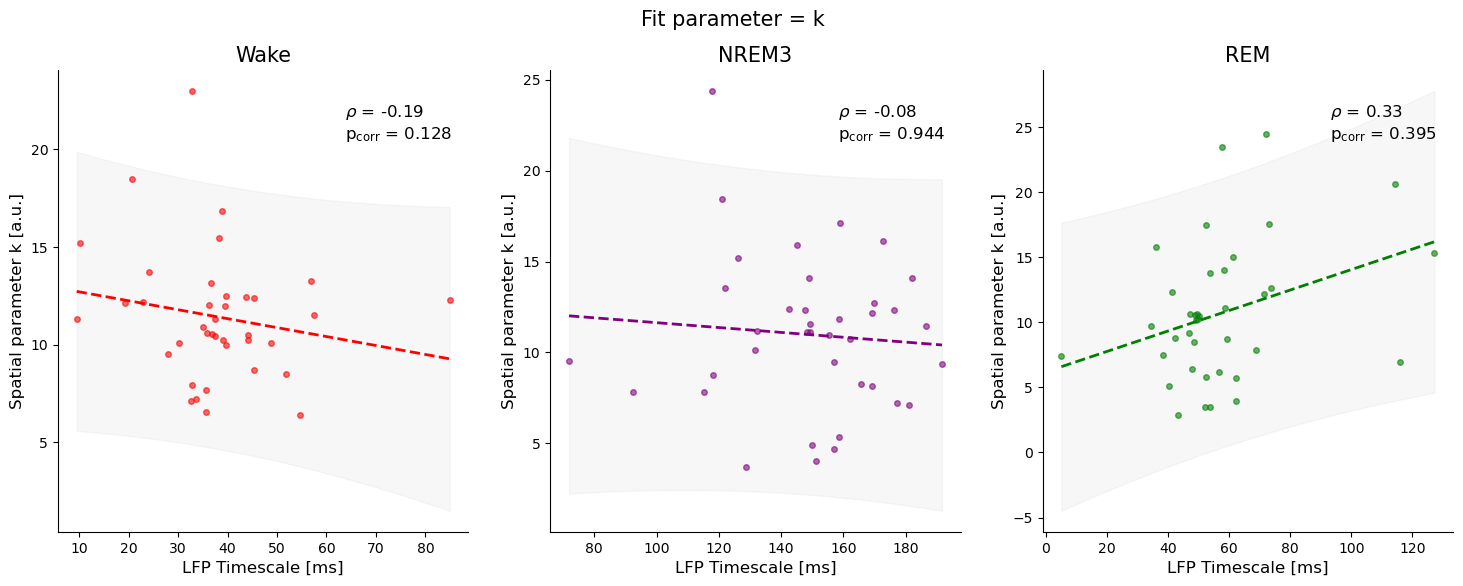

Stage: W, Param: a
Stage: N3, Param: a
Stage: R, Param: a


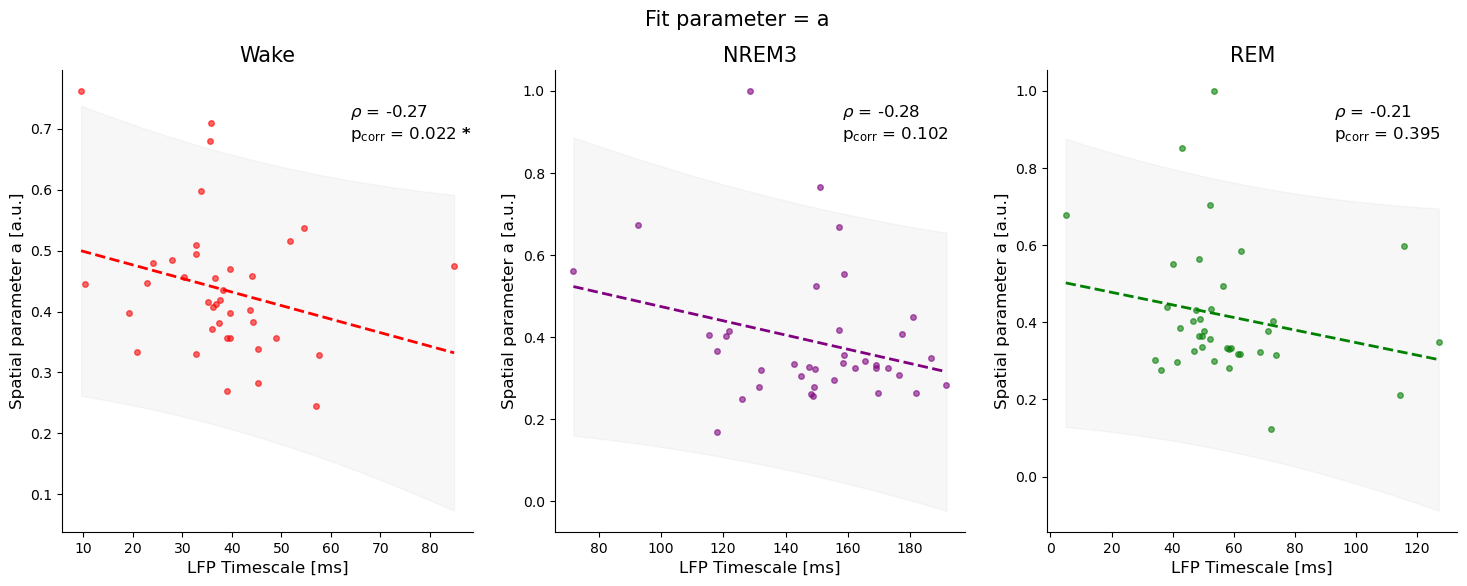

Stage: W, Param: b
Stage: N3, Param: b
Stage: R, Param: b


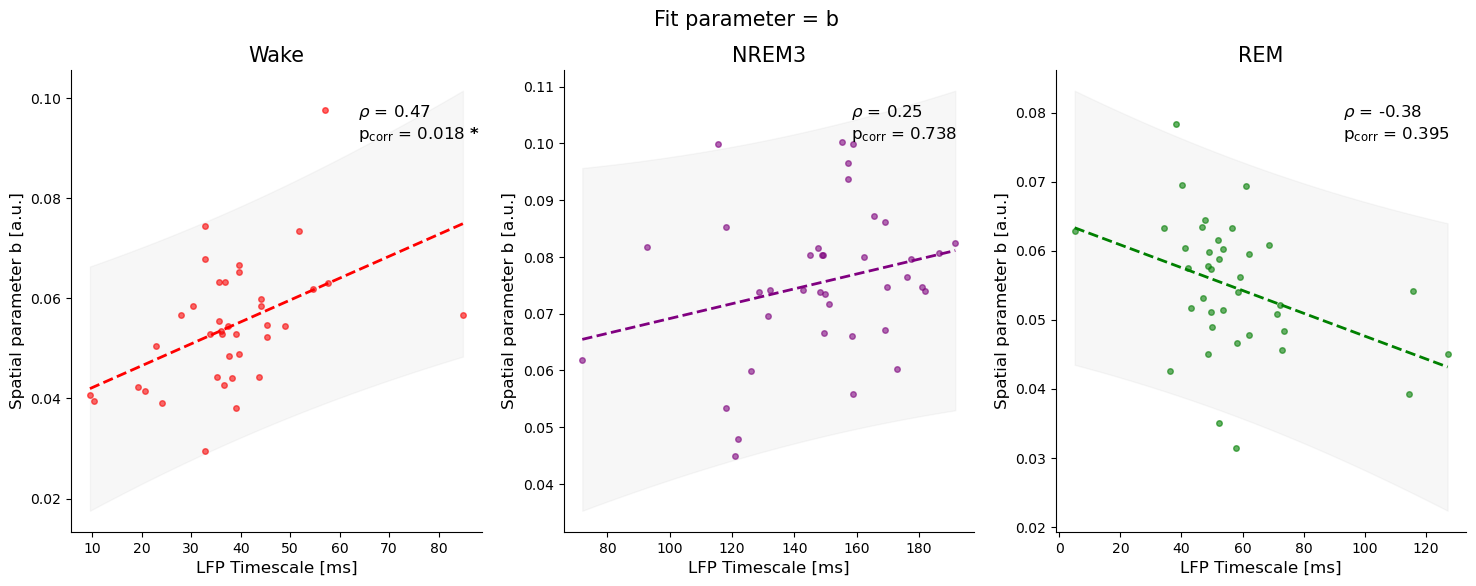

In [64]:
colors_stage = {"W": "r", "N3": "purple", "R": "g"}
title_dict = {"W": "Wake", "N3": "NREM3", "R": "REM"}

# Plot one figure per parameter
for param in ["k", "a", "b"]:

    # Define figure
    fig, axs = plt.subplots(1, 3, figsize=[18, 6])
    fig.suptitle(f"Fit parameter = {param}", fontsize=15)

    # One subplot per stage
    for i, stage in enumerate(["W", "N3", "R"]):
        print(f"Stage: {stage}, Param: {param}")

        # Get average tau per MNI region
        df_tau_stage_mni = uti.get_avg_tau_mni(
            df_tau[df_tau["stage"] == stage].copy(), method="LME"
        )

        # Get spatial parameter
        df_spa = df_sc_params_mni_stages[stage][param].astype(float)
        df_spa = df_spa.loc[df_tau_stage_mni.index]

        # Plot
        axs[i] = plot_corr(
            axs[i],
            df_tau_stage_mni.to_numpy().squeeze(),
            df_spa.to_numpy().squeeze(),
            df_rhos.loc[param, stage],
            df_pvals_corr.loc[param, stage],
            color=colors_stage[stage],
            title=title_dict[stage],
            xlabel="LFP Timescale [ms]",
            ylabel=f"Spatial parameter {param} [a.u.]",
        )

    fig.savefig(fig_path.joinpath("Fig_4", f"Fig4_tau_{param}_corr.svg"), format="svg")
    plt.show()

Gamma:

In [68]:
# Gather all p-values to correct
df_rhos_gamma = pd.DataFrame(index=["k", "a", "b"], columns=["W", "N3", "R"], dtype=float)
df_pvals_gamma = pd.DataFrame(index=["k", "a", "b"], columns=["W", "N3", "R"], dtype=float)
rhos_boot_gamma = {stage: {} for stage in ["W", "N3", "R"]}

# Plot one figure per parameter
for i, stage in enumerate(["W", "N3", "R"]):

    # Get average tau per MNI region
    df_tau_stage_mni = uti.get_avg_tau_mni(
        df_tau_gamma[df_tau_gamma["stage"] == stage].copy(), method="LME"
    )

    for param in ["k", "a", "b"]:

        print(f"Stage: {stage}, Param: {param}")

        # Get spatial parameter
        df_spa = df_sc_params_mni_stages_gamma[stage][param].astype(float)
        df_spa = df_spa.loc[df_tau_stage_mni.index]

        # Get correlation values
        rho, p_corr = uti.get_pcorr_mnia(
            df_tau_stage_mni, df_spa, map_coords, method="vasa", corr_type="pearson"
        )

        df_rhos_gamma.loc[param, stage] = rho
        df_pvals_gamma.loc[param, stage] = p_corr
        rhos_boot_gamma[stage][param] = uti.get_rho_boot(
            df_tau_stage_mni, df_spa, corr_type="pearson"
        )

# Correct with FDR correction
pvals_corr = false_discovery_control(df_pvals_gamma.to_numpy().ravel())
df_pvals_corr_gamma = pd.DataFrame(
    pvals_corr.reshape(df_pvals_gamma.shape), index=df_pvals_gamma.index, columns=df_pvals_gamma.columns
)

Stage: W, Param: k
Generating 1000 permutations...
Stage: W, Param: a
Generating 1000 permutations...
Stage: W, Param: b
Generating 1000 permutations...
Stage: N3, Param: k
Generating 1000 permutations...
Stage: N3, Param: a
Generating 1000 permutations...
Stage: N3, Param: b
Generating 1000 permutations...
Stage: R, Param: k
Generating 1000 permutations...
Stage: R, Param: a
Generating 1000 permutations...
Stage: R, Param: b
Generating 1000 permutations...


Stage: W, Param: k
Stage: N3, Param: k
Stage: R, Param: k


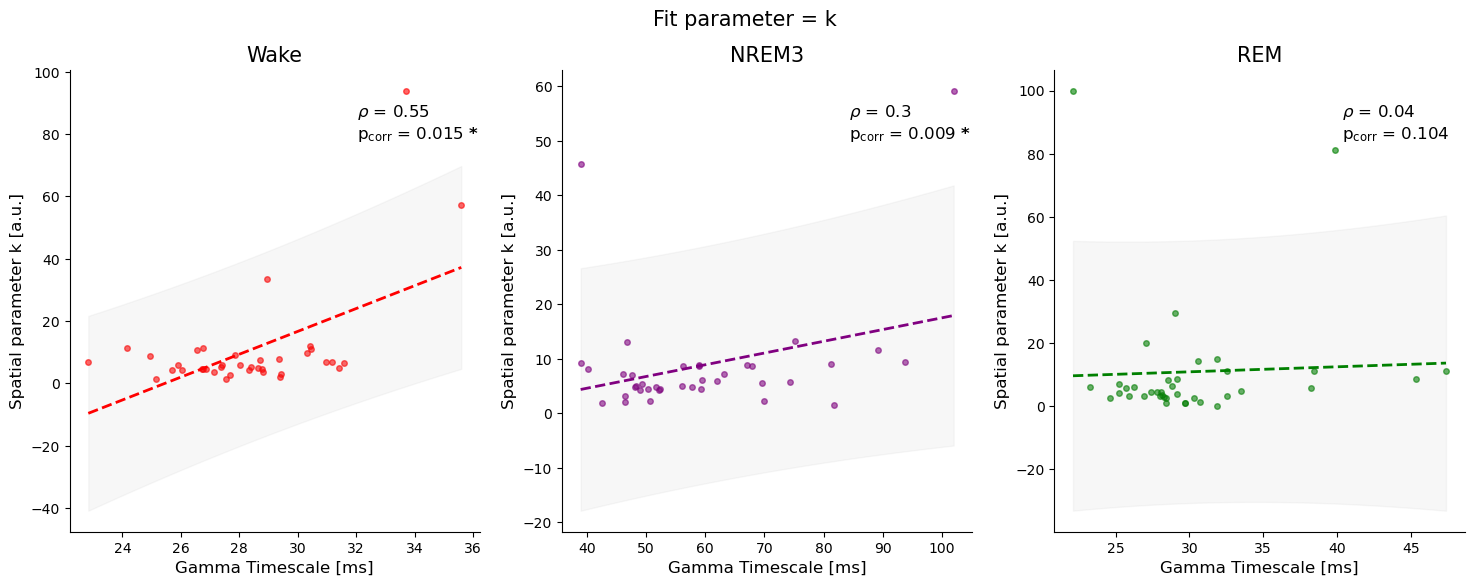

Stage: W, Param: a
Stage: N3, Param: a
Stage: R, Param: a


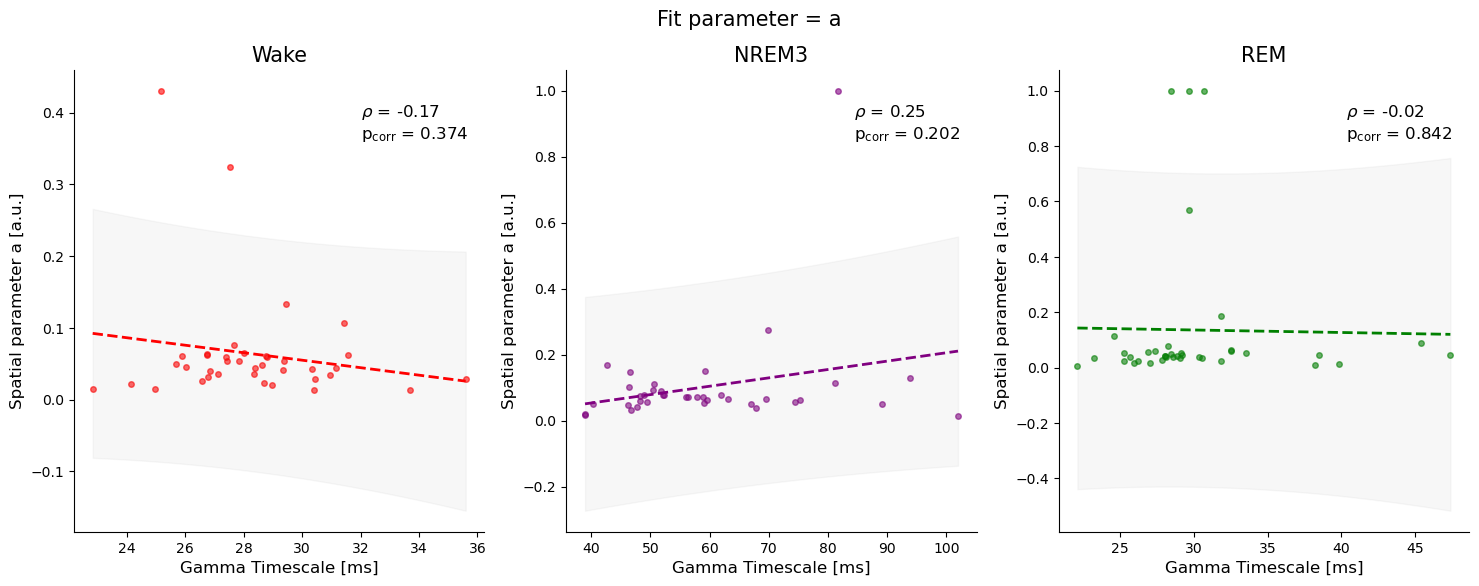

Stage: W, Param: b
Stage: N3, Param: b
Stage: R, Param: b


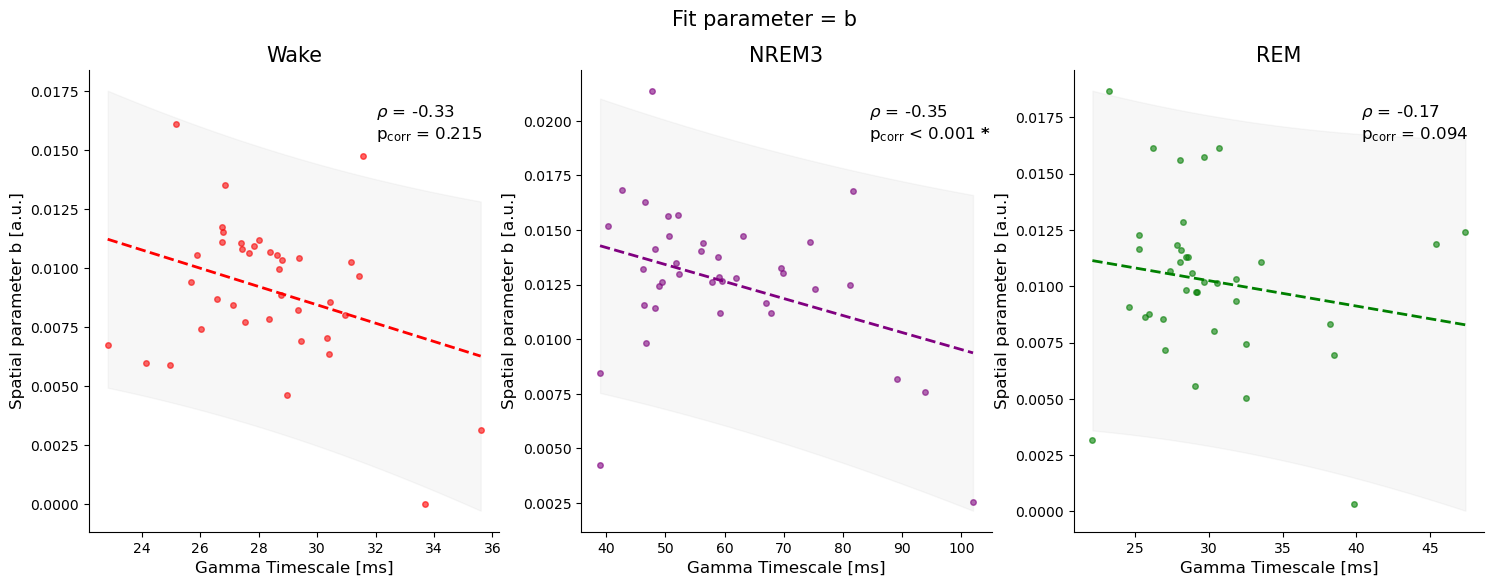

In [71]:
colors_stage = {"W": "r", "N3": "purple", "R": "g"}
title_dict = {"W": "Wake", "N3": "NREM3", "R": "REM"}

# Plot one figure per parameter
for param in ["k", "a", "b"]:

    # Define figure
    fig, axs = plt.subplots(1, 3, figsize=[18, 6])
    fig.suptitle(f"Fit parameter = {param}", fontsize=15)

    # One subplot per stage
    for i, stage in enumerate(["W", "N3", "R"]):
        print(f"Stage: {stage}, Param: {param}")

        # Get average tau per MNI region
        df_tau_stage_mni = uti.get_avg_tau_mni(
            df_tau_gamma[df_tau_gamma["stage"] == stage].copy(), method="LME"
        )

        # Get spatial parameter
        df_spa = df_sc_params_mni_stages_gamma[stage][param].astype(float)
        df_spa = df_spa.loc[df_tau_stage_mni.index]

        # Plot
        axs[i] = plot_corr(
            axs[i],
            df_tau_stage_mni.to_numpy().squeeze(),
            df_spa.to_numpy().squeeze(),
            df_rhos_gamma.loc[param, stage],
            df_pvals_corr_gamma.loc[param, stage],
            color=colors_stage[stage],
            title=title_dict[stage],
            xlabel="Gamma Timescale [ms]",
            ylabel=f"Spatial parameter {param} [a.u.]",
        )

    fig.savefig(
        fig_path.joinpath("Fig_4", f"Fig4_tau_{param}_corr_gamma.svg"), format="svg"
    )
    plt.show()

### E) Correlation with timescales as violin plot

LFP:

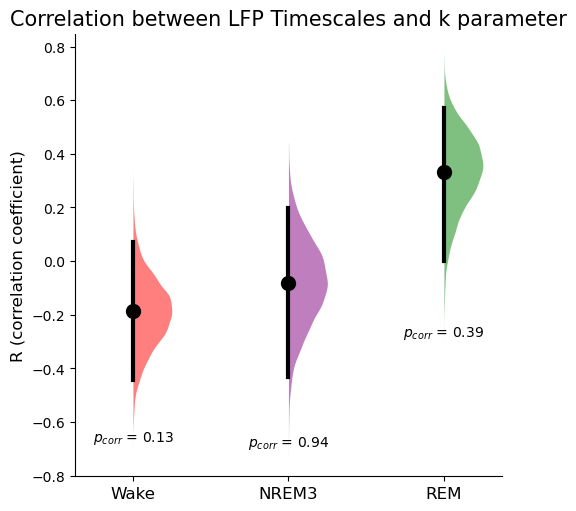

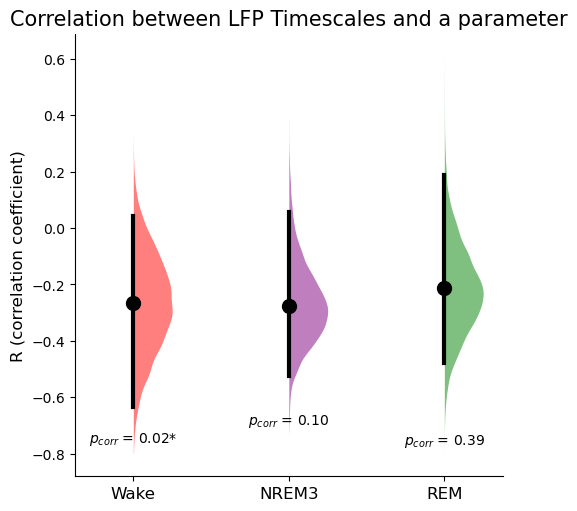

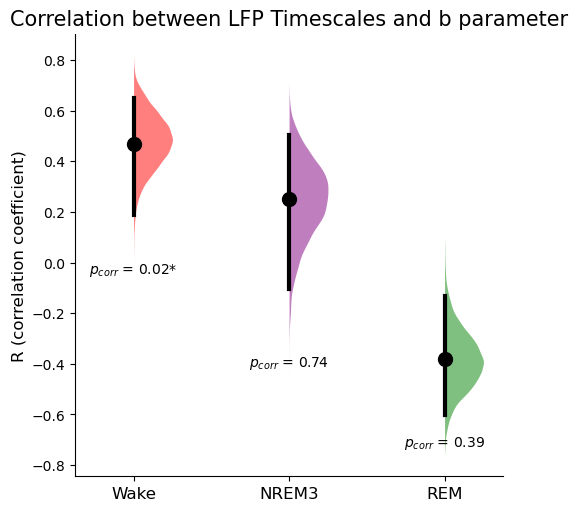

In [72]:
for param in ["k", "a", "b"]:    

    fig, ax = plt.subplots(figsize=(5, 5), layout="constrained")

    for i, stage in enumerate(["W", "N3", "R"]):

        p_str = r"$p_{corr}$ "
        p_str += f"= {df_pvals_corr.loc[param, stage]:.2f}" if df_pvals_corr.loc[param, stage] > 0.001 else "< 0.001"
        p_str += "*" if df_pvals_corr.loc[param, stage] < 0.05 else ""
        half_violin_plot(
            ax,
            df_rhos.loc[param, stage],
            x_pos=i,
            ci=list(rhos_boot[stage][param].confidence_interval),
            y_boot=rhos_boot[stage][param].bootstrap_distribution,
            color=colors_stage[stage],
            pval=p_str,
        )

    ax.set_xticks([0, 1, 2], labels=["Wake", "NREM3", "REM"], fontsize=12)
    # ax.set_ylim(-0.65, 0.3)
    # ax.set_yticks(
    #     [-0.6, -0.4, -0.2, 0.0, 0.2], labels=[-0.6, -0.4, -0.2, 0.0, 0.2], fontsize=10
    # )
    ax.set_ylabel("R (correlation coefficient)", fontsize=12)
    ax.set_title(f"Correlation between LFP Timescales and {param} parameter", fontsize=15)
    ax.spines[["top", "right"]].set_visible(False)

    fig.savefig(
        fig_path.joinpath("Fig_4", f"Fig4_tau_{param}_corr_violin.svg"),
        format="svg",
        bbox_inches="tight",
    )

    plt.show()

Gamma:

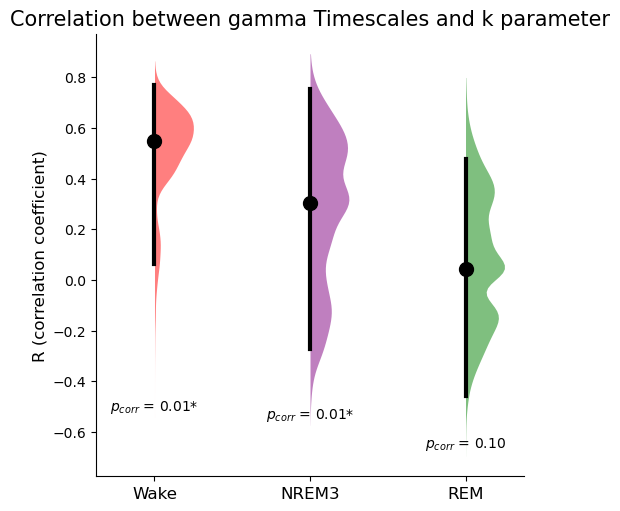

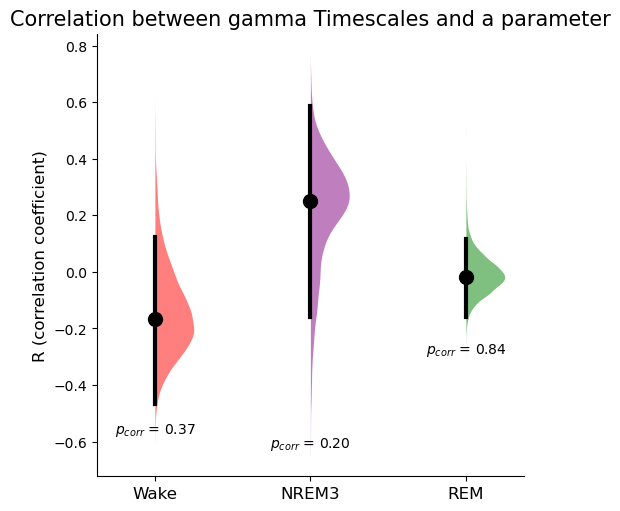

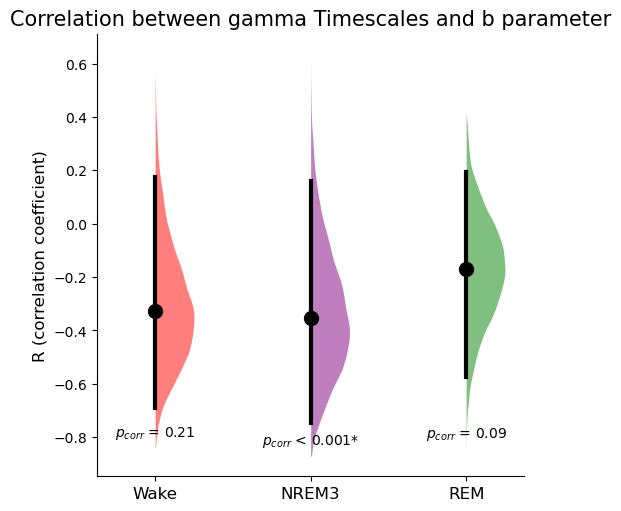

In [73]:
for param in ["k", "a", "b"]:    

    fig, ax = plt.subplots(figsize=(5, 5), layout="constrained")

    for i, stage in enumerate(["W", "N3", "R"]):

        p_str = r"$p_{corr}$ "
        p_str += f"= {df_pvals_corr_gamma.loc[param, stage]:.2f}" if df_pvals_corr_gamma.loc[param, stage] > 0.001 else "< 0.001"
        p_str += "*" if df_pvals_corr_gamma.loc[param, stage] < 0.05 else ""
        half_violin_plot(
            ax,
            df_rhos_gamma.loc[param, stage],
            x_pos=i,
            ci=list(rhos_boot_gamma[stage][param].confidence_interval),
            y_boot=rhos_boot_gamma[stage][param].bootstrap_distribution,
            color=colors_stage[stage],
            pval=p_str,
        )

    ax.set_xticks([0, 1, 2], labels=["Wake", "NREM3", "REM"], fontsize=12)
    # ax.set_ylim(-0.65, 0.3)
    # ax.set_yticks(
    #     [-0.6, -0.4, -0.2, 0.0, 0.2], labels=[-0.6, -0.4, -0.2, 0.0, 0.2], fontsize=10
    # )
    ax.set_ylabel("R (correlation coefficient)", fontsize=12)
    ax.set_title(f"Correlation between gamma Timescales and {param} parameter", fontsize=15)
    ax.spines[["top", "right"]].set_visible(False)

    fig.savefig(
        fig_path.joinpath("Fig_4", f"Fig4_tau_{param}_corr_violin_gamma.svg"),
        format="svg",
        bbox_inches="tight",
    )

    plt.show()